In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [1]:
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
sys.path.append("/home/Developer/NCSN-TF2.0/")

import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from datasets.dataset_loader import  *
from tqdm import tqdm
from sklearn.metrics import classification_report, average_precision_score
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

tf.__version__

'2.2.0'

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
import utils, configs
import argparse

def get_command_line_args(_args):
    parser = utils._build_parser()

    parser = parser.parse_args(_args)

    utils.check_args_validity(parser)

    print("=" * 20 + "\nParameters: \n")
    for key in parser.__dict__:
        print(key + ': ' + str(parser.__dict__[key]))
    print("=" * 20 + "\n")
    return parser


def print_eval(f_train_fashion_score, f_train_mnist_score, f_train_cifar_score ):

    y_true = np.concatenate((np.zeros(TEST_BATCH),
                             np.ones(TEST_BATCH)))
    y_scores_fm = np.concatenate((f_train_fashion_score, f_train_mnist_score))
    y_scores_fc = np.concatenate((f_train_fashion_score, f_train_cifar_score))

    prec,rec,thresh = precision_recall_curve(y_true, y_scores_fm)

    print("Fashion vs MNIST")
    print("----------------")
    print("ROC-AUC: {:.4f}".format(roc_auc_score(y_true,y_scores_fm)))
    # print("PR-AUC: {:.4f}".format(auc(rec,prec)))
    print("Avg Prec: {:.4f}".format(average_precision_score(y_true,y_scores_fm)))
    print()
    print("Fashion vs CIFAR")
    print("--------------")
    print("AUC: {:.4f}".format(roc_auc_score(y_true,y_scores_fc)))
    print("Avg Prec: {:.4f}".format(average_precision_score(y_true,y_scores_fc)))

In [4]:
def metrics(inlier_score, outlier_score, plot=False):
    from sklearn.metrics import roc_curve
    from sklearn.metrics import classification_report, average_precision_score
    from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
    
    y_true = np.concatenate((np.zeros(len(inlier_score)),
                             np.ones(len(outlier_score))))
    y_scores = np.concatenate((inlier_score, outlier_score))
    
    prec,rec,thresh = precision_recall_curve(y_true, y_scores)
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    
    roc_auc = roc_auc_score(y_true,y_scores)
    pr_auc = auc(rec,prec)
    ap = average_precision_score(y_true,y_scores)
    
#     print("Inlier vs Outlier")
#     print("----------------")
#     print("ROC-AUC: {:.4f}".format(roc_auc))
#     print("PR-AUC: {:.4f}".format(pr_auc))
#     print("Avg Prec: {:.4f}".format(ap))
    
    if plot:    
    
        fig, axs = plt.subplots(1,2, figsize=(16,4))

        sns.lineplot(fpr, tpr, ax=axs[0])
        axs[0].set(
            xlabel="FPR", ylabel="TPR", title="ROC"
        )

        sns.lineplot(rec, prec, ax=axs[1])
        axs[1].set(
            xlabel="Recall", ylabel="Precision", title="Precision-Recall"
        )

        plt.show()
        plt.close()
        
    return roc_auc, ap, pr_auc

In [5]:
TEST_BATCH = 1000

@tf.function
def preproc(x):
    img, mask = tf.split(x, (3,1), axis=-1)
    img = tf.image.rgb_to_grayscale(img)
    img = tf.image.resize(img, size=[28,28])
    mask = tf.image.resize(mask, size=[28,28], method="nearest")
    
    return tf.concat((img,mask), axis=-1)

@tf.function()
def add_mask(x):
    return tf.concat((x, tf.cast(x>0, dtype=tf.float32)),
                  axis=-1)

with tf.device('CPU'):
    # load dataset from tfds (or use downloaded version if exists)
    fashion_test = get_train_test_data("masked_fashion")[1]
    fashion_test = fashion_test.batch(TEST_BATCH)
    fashion_test = fashion_test.cache().take(1)

    mnist_test = get_train_test_data("mnist")[1]
    mnist_test = mnist_test.map(add_mask)
    mnist_test = mnist_test.batch(TEST_BATCH)
    mnist_test = mnist_test.cache().take(1)
    
    cifar_test = get_train_test_data("masked_cifar10")[1]
    cifar_test = cifar_test.map(preproc)
    cifar_test = cifar_test.shuffle(10000).batch(TEST_BATCH)
    cifar_test = cifar_test.cache().take(1)

## FashionMNIST - Baseline --sigma_low=0.01

In [6]:
args = get_command_line_args(["--model=refinenet",
                              "--checkpoint_dir=./saved_models/",
                              "--filters=64",
                              "--dataset=masked_fashion",
                              "--sigma_low=0.01",
                              "--sigma_high=1",
                              "--y_cond"
                             ])
configs.config_values = args
NUM_L = configs.config_values.num_L
SIGMA_HIGH = configs.config_values.sigma_high
SIGMA_LOW = configs.config_values.sigma_low
BEST_SIGMA_IDX = configs.config_values.num_L - 1
SIGMA_LEVELS = tf.math.exp(tf.linspace(tf.math.log(SIGMA_HIGH),
                                       tf.math.log(SIGMA_LOW),
                                       NUM_L))

Parameters: 

experiment: train
dataset: masked_fashion
model: refinenet
filters: 64
num_L: 10
sigma_low: 0.01
sigma_high: 1.0
sigma_sequence: geometric
steps: 200000
learning_rate: 0.001
batch_size: 128
samples_dir: ./samples/
checkpoint_dir: ./saved_models/
checkpoint_freq: 5000
resume: True
resume_from: -1
init_samples: 
k: 10
eval_setting: sample
ocnn: False
y_cond: True
max_to_keep: 2



In [7]:
# save_dir, complete_model_name = utils.get_savemodel_dir()
# fashion_model, _, step, _,_ = utils.try_load_model(save_dir,
#                                               step_ckpt=configs.config_values.resume_from,
#                                               verbose=True)

In [8]:
save_dir, complete_model_name = utils.get_savemodel_dir() 
fashion_model, optimizer, step, _, _ = utils.try_load_model("saved_models/"+"vanilla_loss_"+complete_model_name,
                                              step_ckpt=configs.config_values.resume_from,
                                              verbose=True)

(1, 28, 28, 2)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
images (InputLayer)             [(None, 28, 28, 2)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 64)   1216        images[0][0]                     
__________________________________________________________________________________________________
idx_sigmas (InputLayer)         [(None,)]            0                                            
__________________________________________________________________________________________________
conditional_full_pre_activation (None, 28, 28, 64)   77696       conv2d[0][0]                     
                                                                 idx_sigmas[0][

In [9]:
sigmas = utils.get_sigma_levels().numpy()
sigmas

array([1.        , 0.5994842 , 0.35938135, 0.21544345, 0.12915495,
       0.07742635, 0.04641588, 0.02782559, 0.016681  , 0.01      ],
      dtype=float32)

### Getting Score Distributions

In [10]:
%%time

idx_sigmas = tf.ones(TEST_BATCH,dtype=tf.int32) * BEST_SIGMA_IDX

for fashion_,mnist_,cifar_ in zip(fashion_test,mnist_test,cifar_test):    
    fashion_logits = fashion_model([fashion_, idx_sigmas])
    mnist_logits = fashion_model([mnist_, idx_sigmas])
    cifar_logits = fashion_model([cifar_, idx_sigmas])

CPU times: user 5.77 s, sys: 4.39 s, total: 10.2 s
Wall time: 4.83 s


In [11]:
# L2-norm same as Frobenius
f_train_fashion_score = tf.norm(fashion_logits, axis=[1,2], ord="euclidean").numpy()
f_train_mnist_score = tf.norm(mnist_logits, axis=[1,2], ord="euclidean").numpy()
f_train_cifar_score = tf.norm(cifar_logits, axis=[1,2], ord="euclidean").numpy()

In [12]:
df = pd.DataFrame(np.hstack((f_train_fashion_score,
                             f_train_mnist_score,
                             f_train_cifar_score)),
             columns=["Fashion", "MNIST", "Cifar"])
df.describe()

,Fashion,MNIST,Cifar
count,1000.000000,1000.000000,1000.000000
mean,769.762390,543.436035,1036.923950
std,232.619171,106.364876,195.595779
min,175.614639,212.038422,314.494598
25%,594.579666,471.104492,923.023758
50%,766.138123,540.690186,1042.628235
75%,952.491241,614.938370,1151.315094
max,1419.569336,898.298096,1658.050537


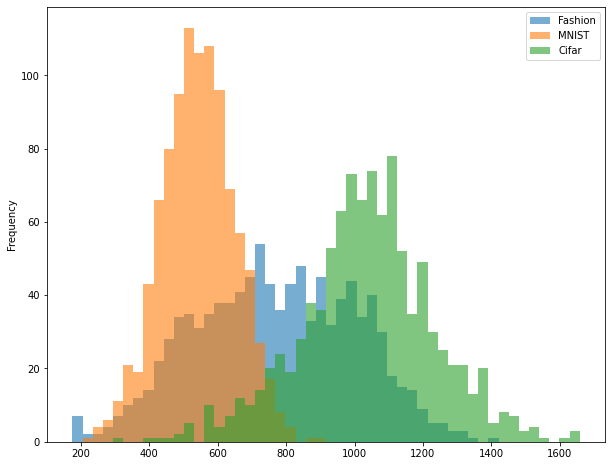

In [13]:
df.plot(kind="hist", bins=50, alpha=0.6, figsize=(10,8))

In [14]:
y_true = np.concatenate((np.zeros(TEST_BATCH),
                         np.ones(TEST_BATCH)))
y_scores_fm = np.concatenate((f_train_fashion_score, f_train_mnist_score))
y_scores_fc = np.concatenate((f_train_fashion_score, f_train_cifar_score))

prec,rec,thresh = precision_recall_curve(y_true, y_scores_fm)

print("Fashion vs MNIST")
print("----------------")
print("ROC-AUC: {:.4f}".format(roc_auc_score(y_true,y_scores_fm)))
# print("PR-AUC: {:.4f}".format(auc(rec,prec)))
print("Avg Prec: {:.4f}".format(average_precision_score(y_true,y_scores_fm)))
print()
print("Fashion vs CIFAR")
print("--------------")
print("AUC: {:.4f}".format(roc_auc_score(y_true,y_scores_fc)))
print("Avg Prec: {:.4f}".format(average_precision_score(y_true,y_scores_fc)))


Fashion vs MNIST
----------------
ROC-AUC: 0.2015
Avg Prec: 0.3452

Fashion vs CIFAR
--------------
AUC: 0.8066
Avg Prec: 0.7920


In [15]:
def compute_scores(x_test):
    logits_shape = (TEST_BATCH,28,28,1)
    
    # Sigma Idx -> Score
    score_dict = []
    
    sigmas = utils.get_sigma_levels().numpy()
    final_logits = tf.zeros(logits_shape)
    progress_bar = tqdm(sigmas, desc='Sigma: ?')
    for idx, sigma in enumerate(progress_bar):
        
        progress_bar.set_description("Sigma: {:.4f}".format(sigma))
        _logits =[]
        idx_sigmas = tf.ones(TEST_BATCH,dtype=tf.int32) * idx

        for x_batch in x_test:
            score = fashion_model([x_batch, idx_sigmas])
#             x_batch, y_cond = tf.split(x_batch, SPLITS, axis=-1)
#             score = tf.where(x_batch > 1e-10, score,  0)
            _logits.append(score)

        _logits = tf.concat(_logits, axis=0)
        score_dict.append(tf.identity(_logits))
        
        final_logits += _logits * sigma
    
    return score_dict, final_logits

In [16]:
%%time
fashion_dist, fashion_logits = compute_scores(fashion_test)
mnist_dist, mnist_logits = compute_scores(mnist_test)
cifar_dist, cifar_logits = compute_scores(cifar_test)

Sigma: 0.0100: 100%|██████████| 10/10 [00:21<00:00,  2.11s/it]

CPU times: user 36.8 s, sys: 16.9 s, total: 53.7 s
Wall time: 37.6 s


In [17]:
# L2-norm same as Frobenius
f_train_fashion_score = tf.norm(fashion_logits, axis=[1,2], ord="euclidean").numpy()
f_train_mnist_score = tf.norm(mnist_logits, axis=[1,2], ord="euclidean").numpy()
f_train_cifar_score = tf.norm(cifar_logits, axis=[1,2], ord="euclidean").numpy()

In [18]:
df = pd.DataFrame(np.hstack((f_train_fashion_score,
                             f_train_mnist_score,
                             f_train_cifar_score)),
             columns=["Fashion", "MNIST", "Cifar"])
df.describe()

,Fashion,MNIST,Cifar
count,1000.000000,1000.000000,1000.000000
mean,61.294029,64.908615,46.813255
std,12.053719,7.215436,5.069829
min,31.084480,37.920300,35.963306
25%,52.785022,60.657526,43.462015
50%,61.305933,65.169628,46.321735
75%,69.657066,69.671789,49.964165
max,104.501511,89.068138,67.895134


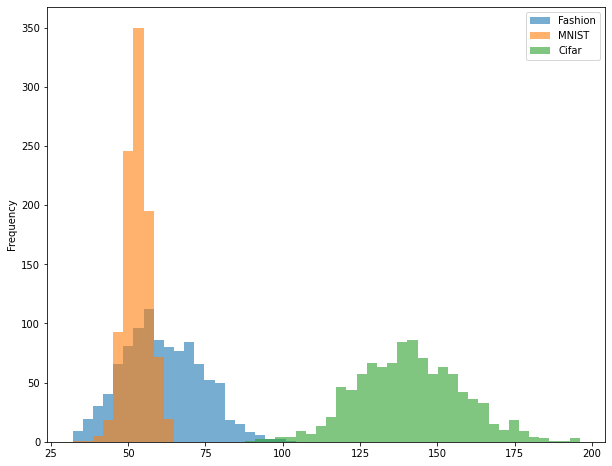

In [27]:
df.plot(kind="hist", bins=50, alpha=0.6, figsize=(10,8))

In [28]:
y_true = np.concatenate((np.zeros(TEST_BATCH),
                         np.ones(TEST_BATCH)))
y_scores_fm = np.concatenate((f_train_fashion_score, f_train_mnist_score))
y_scores_fc = np.concatenate((f_train_fashion_score, f_train_cifar_score))

prec,rec,thresh = precision_recall_curve(y_true, y_scores_fm)

print("Fashion vs MNIST")
print("----------------")
print("ROC-AUC: {:.4f}".format(roc_auc_score(y_true,y_scores_fm)))
# print("PR-AUC: {:.4f}".format(auc(rec,prec)))
print("Avg Prec: {:.4f}".format(average_precision_score(y_true,y_scores_fm)))
print()
print("Fashion vs CIFAR")
print("--------------")
print("AUC: {:.4f}".format(roc_auc_score(y_true,y_scores_fc)))
print("Avg Prec: {:.4f}".format(average_precision_score(y_true,y_scores_fc)))


Fashion vs MNIST
----------------
ROC-AUC: 0.2911
Avg Prec: 0.3705

Fashion vs CIFAR
--------------
AUC: 1.0000
Avg Prec: 1.0000


### Visualizing Sigma Distributions

Sigma: ?: 100%|██████████| 10/10 [00:00<00:00, 15.56it/s]


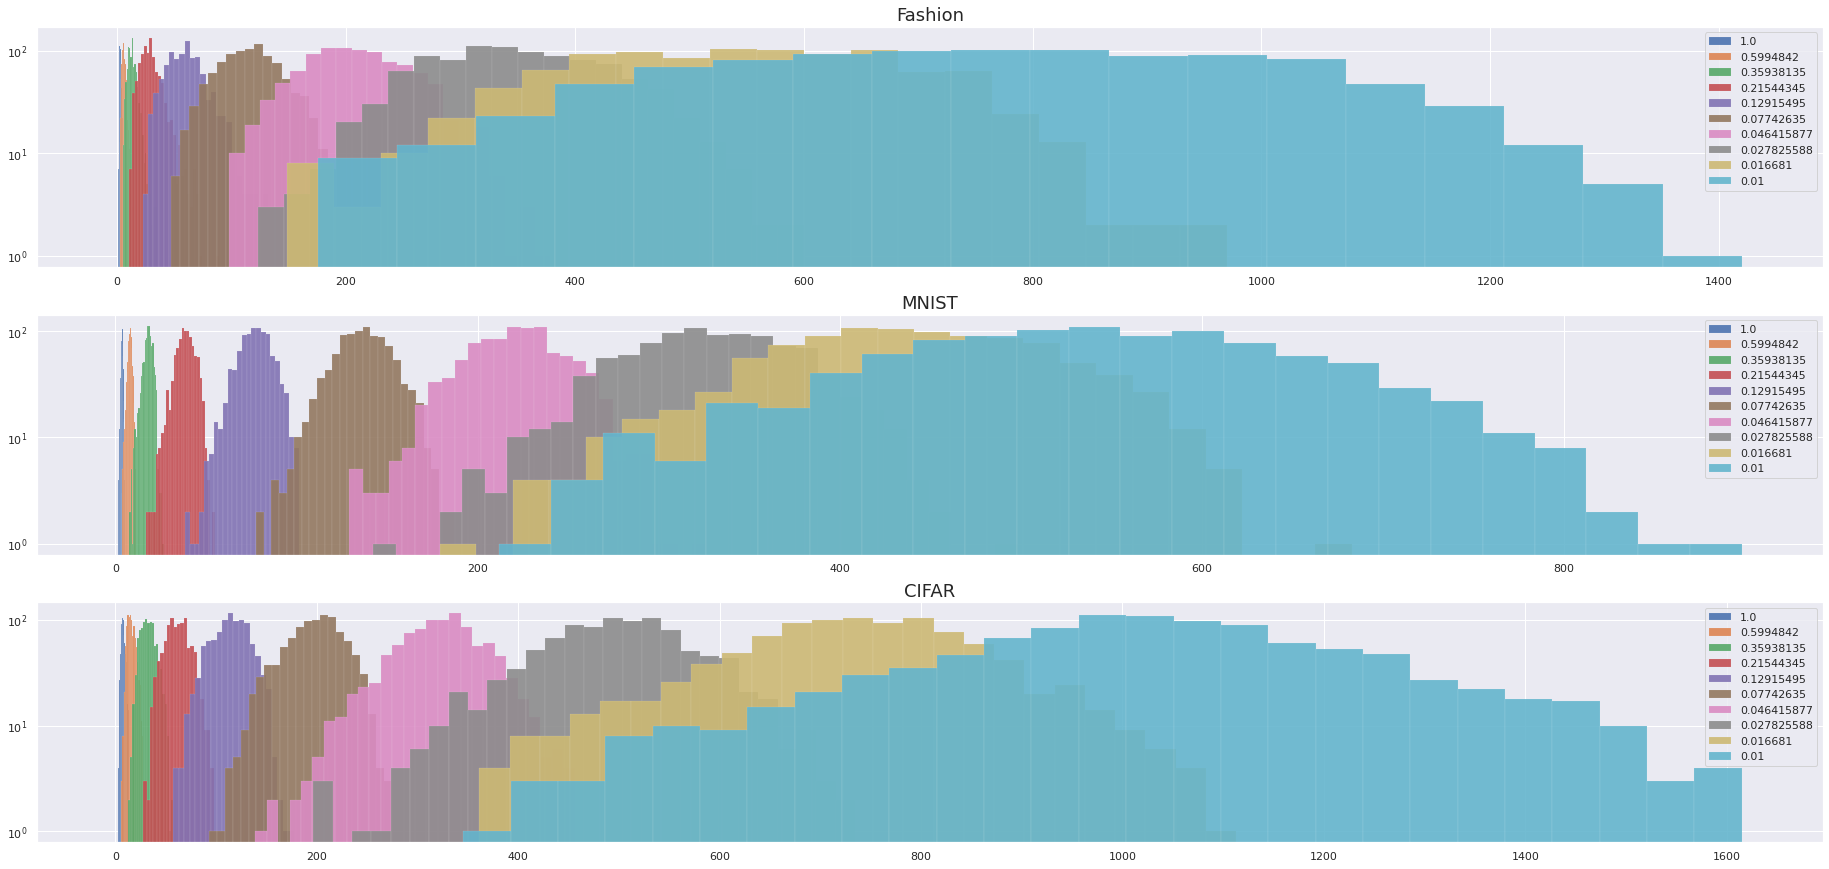

In [25]:
progress_bar = tqdm(sigmas, desc='Sigma: ?')
fig, axs = plt.subplots(3,1, figsize=(32,15))

for i, score_dict in enumerate([fashion_dist, mnist_dist, cifar_dist]):
    for idx, sigma in enumerate(progress_bar):
        _logits = score_dict[idx]
        _score =  tf.norm(_logits, axis=[1,2], ord="euclidean").numpy()
        sns.distplot(_score, label=sigma, ax=axs[i], hist_kws={"alpha":0.9, "linewidth": 0.1, "log":True}, kde=False)
        axs[i].legend()
        
axs[0].set(title="Fashion")    
axs[1].set(title="MNIST") 
axs[2].set(title="CIFAR")
plt.show()

Sigma: ?: 100%|██████████| 10/10 [00:00<00:00, 31.03it/s]


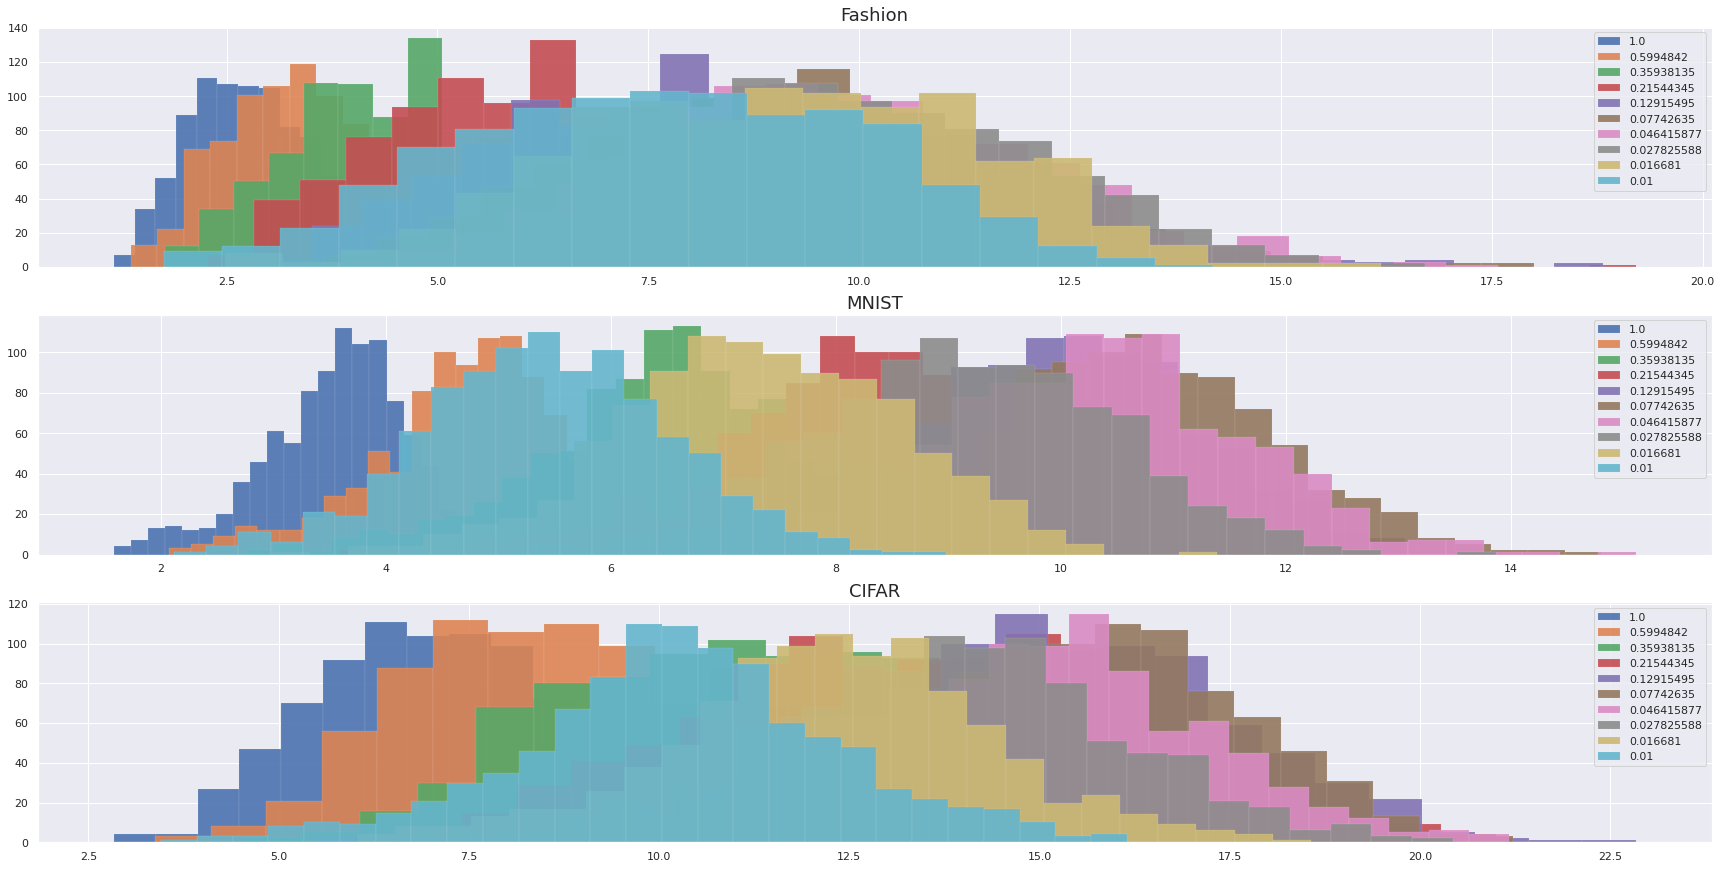

In [26]:
progress_bar = tqdm(sigmas, desc='Sigma: ?')
fig, axs = plt.subplots(3,1, figsize=(30,15))

for i, score_dict in enumerate([fashion_dist, mnist_dist, cifar_dist]):
    for idx, sigma in enumerate(progress_bar):
        _logits = score_dict[idx] * sigma
        _score =  tf.norm(_logits, axis=[1,2], ord="euclidean").numpy()
        sns.distplot(_score, label=sigma, ax=axs[i], hist_kws={"alpha":0.9, "linewidth": 0.1, "log":False}, kde=False)
        axs[i].legend()
        
axs[0].set(title="Fashion")    
axs[1].set(title="MNIST") 
axs[2].set(title="CIFAR")
plt.show()

In [20]:
sigmas

array([1.        , 0.5994842 , 0.35938135, 0.21544345, 0.12915495,
       0.07742635, 0.04641588, 0.02782559, 0.016681  , 0.01      ],
      dtype=float32)

In [27]:
df_arr = []

for (x_dist, name) in zip([fashion_dist, mnist_dist, cifar_dist],
                        ["Fashion", "MNIST", "CIFAR"]):
    print(name)
    dist_tf = tf.squeeze(tf.stack(x_dist)) * sigmas.reshape(-1,1,1,1)
    norms = tf.norm(dist_tf, axis=[2,3], ord="euclidean").numpy()
    _df = pd.DataFrame(norms.T, columns=["{:.2f}".format(x) for x in sigmas])
    _df["ID"] = _df.index
    _df["Type"] = name
    
    df_arr.append(_df.copy())

df = pd.concat(df_arr)

melted=df.melt(id_vars=["ID", "Type"], var_name="sigma", value_name="score")
# melted

Fashion
MNIST
CIFAR


In [28]:
df.shape

(3000, 12)

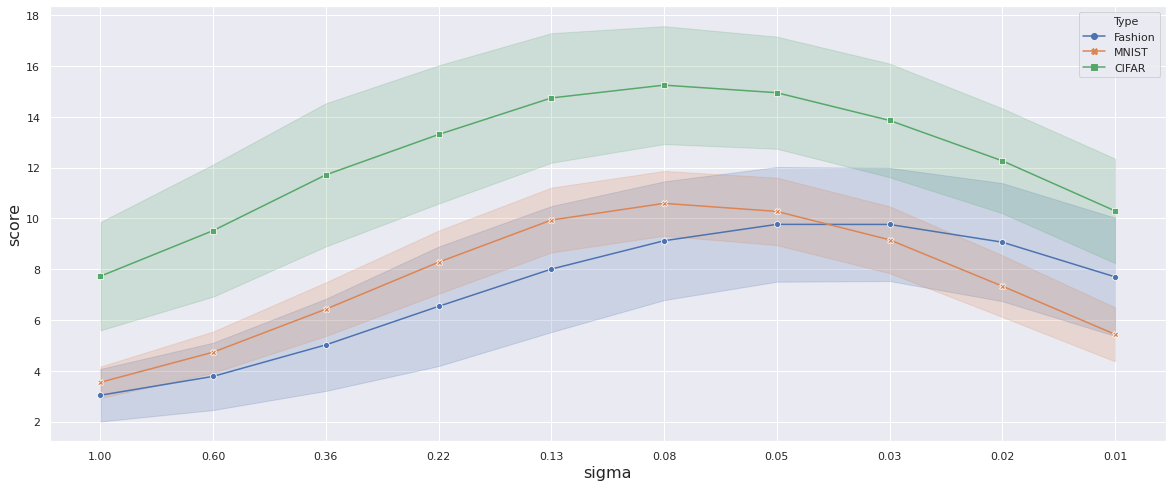

CPU times: user 652 ms, sys: 28.6 ms, total: 681 ms
Wall time: 676 ms


In [29]:
%%time
fig, ax = plt.subplots(1,1, figsize=(20,8))
sns.lineplot(x="sigma", y="score", hue="Type", data=melted, err_style="band", ci="sd", ax=ax, style="Type", markers=True, dashes=False)
ax.invert_xaxis()
ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
plt.show()

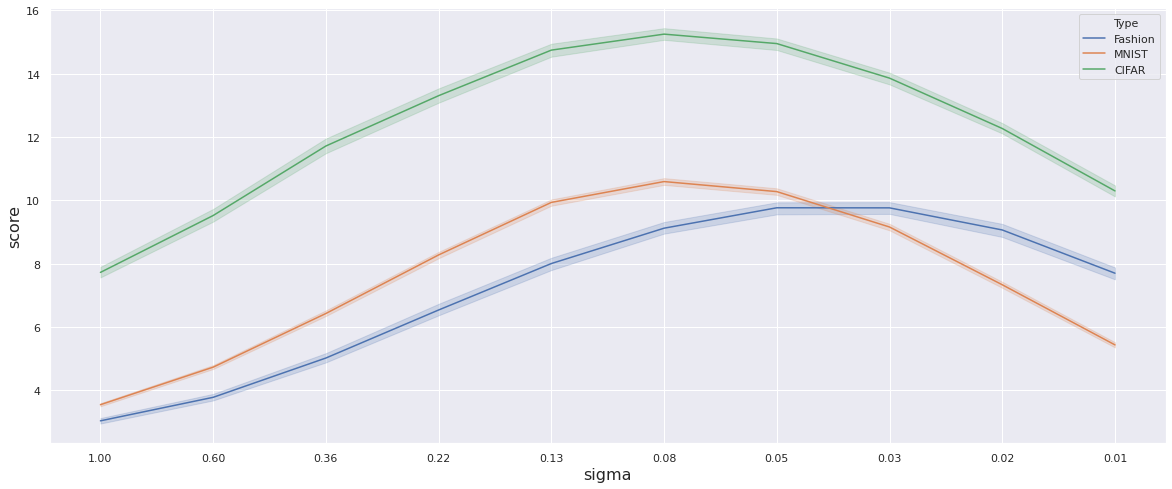

CPU times: user 2.1 s, sys: 59.7 ms, total: 2.16 s
Wall time: 2.15 s


In [30]:
%%time
fig, ax = plt.subplots(1,1, figsize=(20,8))
sns.lineplot(x="sigma", y="score", hue="Type", data=melted, err_style="band", ci=99, ax=ax)
ax.invert_xaxis()
ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
plt.show()

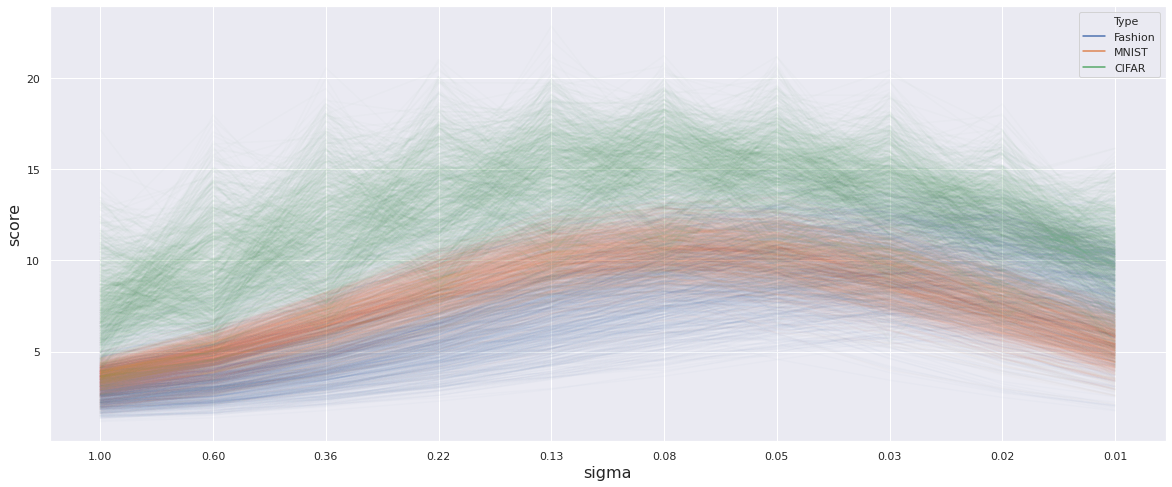

CPU times: user 7.77 s, sys: 313 ms, total: 8.09 s
Wall time: 8.07 s


In [31]:
%%time
fig, ax = plt.subplots(1,1, figsize=(20,8))
sns.lineplot(x="sigma", y="score", hue="Type", data=melted, units="ID", estimator=None, alpha=0.02, ax=ax)
ax.invert_xaxis()
plt.show()

In [77]:
# progress_bar = tqdm(sigmas, desc='Sigma: ?')
# fig, axs = plt.subplots(5,2, figsize=(16,20))
# axs = axs.flatten()

# for idx, sigma in enumerate(progress_bar):
#     for (score_dist, name) in zip([fashion_dist, mnist_dist, cifar_dist], 
#                               ["Fashion", "MNIST", "CIFAR"]):
#         _logits = score_dist[idx] * sigma
#         _score =  tf.norm(_logits, axis=[1,2], ord="euclidean").numpy()
#         sns.distplot(_score, label=name, ax=axs[idx], hist_kws={"alpha":0.7}, kde=True)
    
#     textstr = '\n'.join((
#         'AUC',
#         "-----",
#         'F vs M=%.2f' % (0.433, ),
#         'F vs C=%.2f' % (0.992, )))

#     # these are matplotlib.patch.Patch properties
#     props = dict(boxstyle='round', alpha=0.5)

#     # place a text box in upper left in axes coords
#     axs[idx].text(0.05, 0.95, textstr, transform=axs[idx].transAxes, fontsize=14,
#             verticalalignment='top', bbox=props)
        
#     break
# axs[0].legend()
# plt.show()

Sigma: ?: 100%|██████████| 10/10 [00:01<00:00,  9.04it/s]


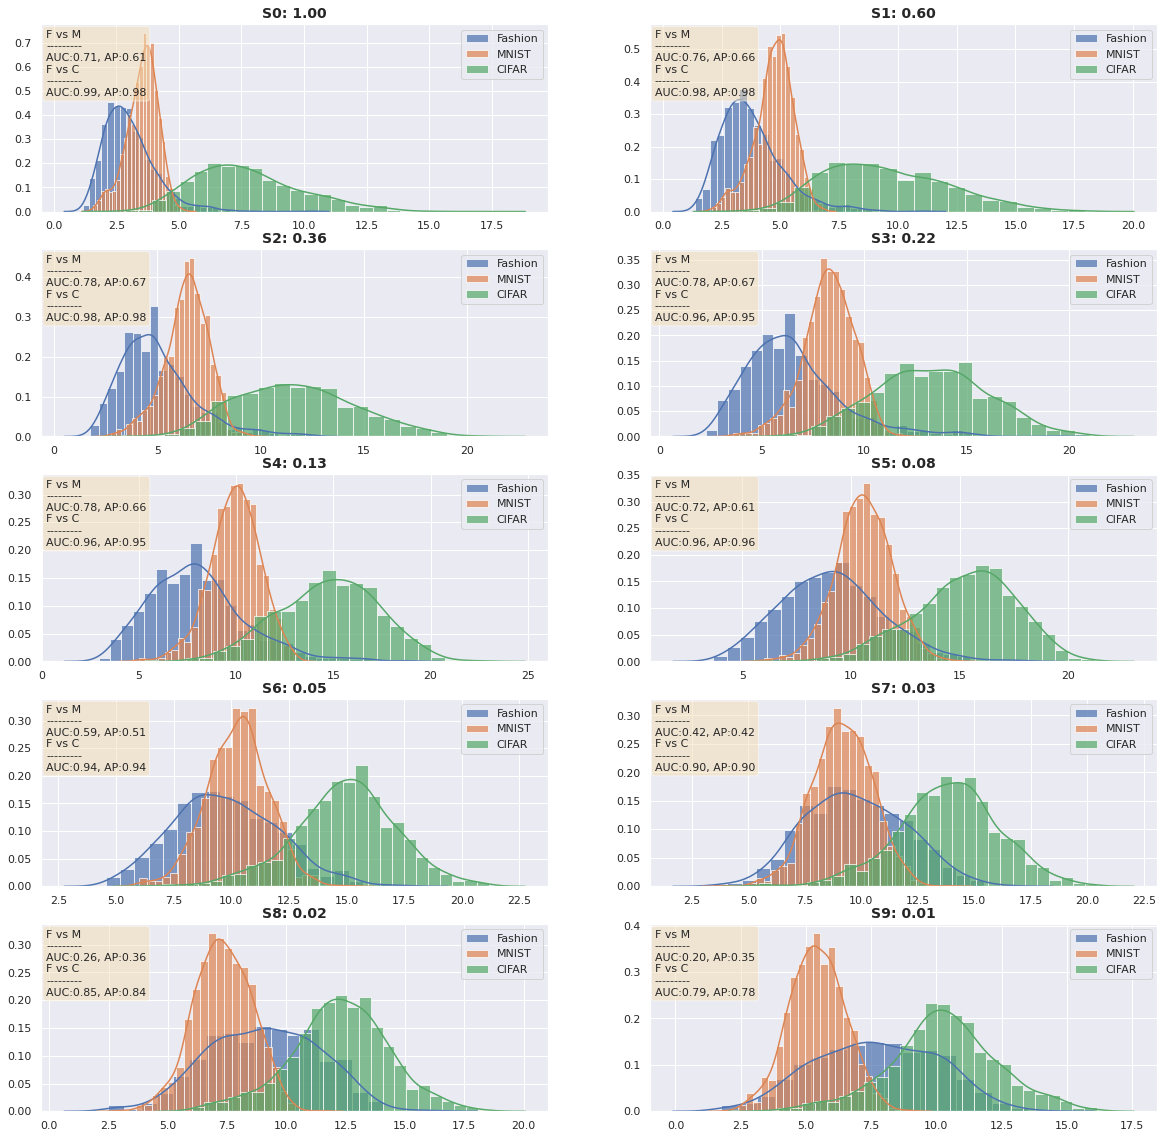

In [32]:
progress_bar = tqdm(sigmas, desc='Sigma: ?')
fig, axs = plt.subplots(5,2, figsize=(20,20))
axs = axs.flatten()

for idx, sigma in enumerate(progress_bar):

    # Fashion Scores
    f_logits = fashion_dist[idx] * sigma
    f_score =  tf.norm(f_logits, axis=[1,2], ord="euclidean").numpy()
    sns.distplot(f_score, label="Fashion", ax=axs[idx], hist_kws={"alpha":0.7}, kde=True)
    
    m_logits = mnist_dist[idx] * sigma
    m_score =  tf.norm(m_logits, axis=[1,2], ord="euclidean").numpy()
    sns.distplot(m_score, label="MNIST", ax=axs[idx], hist_kws={"alpha":0.7}, kde=True)
    
    c_logits = cifar_dist[idx] * sigma
    c_score =  tf.norm(c_logits, axis=[1,2], ord="euclidean").numpy()
    sns.distplot(c_score, label="CIFAR", ax=axs[idx], hist_kws={"alpha":0.7}, kde=True)
    
    textstr = '\n'.join((
        'F vs M',
        "---------",
        'AUC:%.2f, AP:%.2f' % (metrics(f_score, m_score)[:-1]),
        'F vs C',
        "---------",
        'AUC:%.2f, AP:%.2f' % (metrics(f_score, c_score)[:-1])))

    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    # place a text box in upper left in axes coords
    axs[idx].text(0.01, 0.97, textstr, transform=axs[idx].transAxes, fontsize=11,
            verticalalignment='top', bbox=props)
    
    axs[idx].set_title("S{:d}: {:.2f}".format(idx, sigma), fontsize=14, fontweight="bold")

    axs[idx].legend()
    
plt.show()

### Picking "best" sigmas

In [151]:
sigmas

array([1.        , 0.5994842 , 0.35938135, 0.21544345, 0.12915495,
       0.07742635, 0.04641588, 0.02782559, 0.016681  , 0.01      ],
      dtype=float32)

In [35]:
# L2-norm same as Frobenius
idx_range = range(0,4)
inlier_agg = tf.add_n([fashion_dist[x] * sigmas[x] for x in idx_range])
outlier_agg = tf.add_n([mnist_dist[x] * sigmas[x] for x in idx_range])
outlier_agg_2 = tf.add_n([cifar_dist[x] * sigmas[x] for x in idx_range])

f_score = tf.norm(inlier_agg, axis=[1,2], ord="euclidean").numpy()
m_score = tf.norm(outlier_agg, axis=[1,2], ord="euclidean").numpy()
c_score = tf.norm(outlier_agg_2, axis=[1,2], ord="euclidean").numpy()

df = pd.DataFrame(np.concatenate((f_score, 
                                  m_score,
                                  c_score), axis=-1),
             columns=["Fashion", "MNIST", "CIFAR"])
df.describe()

,Fashion,MNIST,CIFAR
count,1000.000000,1000.000000,1000.000000
mean,17.843208,22.466511,24.520403
std,6.269981,3.607430,4.059285
min,6.209565,9.889489,14.257185
25%,13.577467,20.547636,21.551765
50%,16.933387,22.755317,24.210176
75%,21.049467,24.956290,27.230556
max,45.503574,32.280624,44.566216


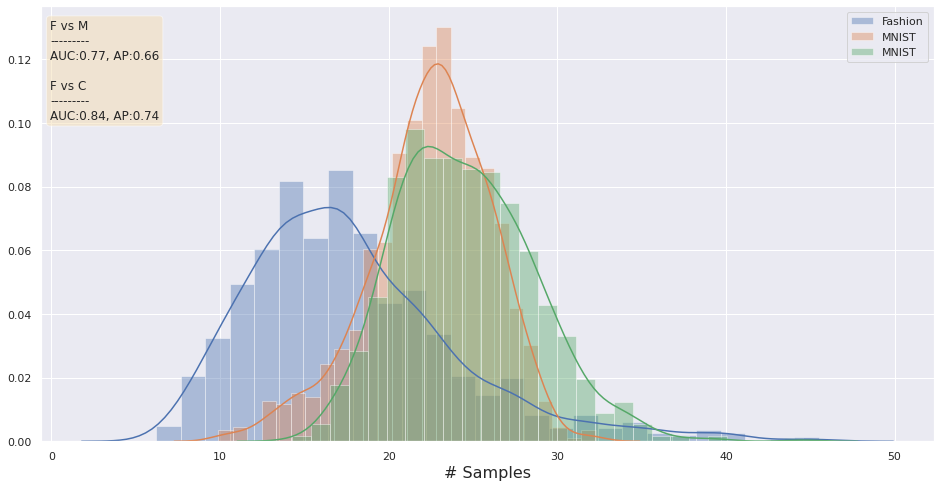

In [36]:
fig, ax = plt.subplots(1,1, figsize=(16,8))
sns.distplot(f_score, label="Fashion", ax=ax)
sns.distplot(m_score, label="MNIST", ax=ax)
sns.distplot(c_score, label="MNIST", ax=ax, axlabel="# Samples")

textstr = '\n'.join((
    'F vs M',
    "---------",
    'AUC:%.2f, AP:%.2f' % (metrics(f_score, m_score)[:-1]),
    '',
    'F vs C',
    "---------",
    'AUC:%.2f, AP:%.2f' % (metrics(f_score, c_score)[:-1])))

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.01, 0.97, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)


plt.legend()
plt.show()

## Training Distribution

In [8]:
with tf.device('CPU'):
    # load dataset from tfds (or use downloaded version if exists)
    fashion_train_ = get_train_test_data("fashion_mnist")[0]
    fashion_train_ = fashion_train_.batch(60000).take(1)

train_samples = next(iter(fashion_train_)) 

In [109]:
%%time
train_dist = compute_scores(train_samples)

### Removing "Background" Effect 

In [8]:
# (fashion_ != x_batch).numpy().sum()

In [9]:
# fashion_model([fashion_,idx_sigmas])

In [17]:
inlier_logits = []
ood_logits = []

for i, sigma_i in enumerate(tqdm(sigmas,desc='Sampling for each sigma')):
    idx_sigmas = tf.ones(TEST_BATCH,dtype=tf.int32) * i

    inlier_logits.append(fashion_model([fashion_, idx_sigmas]))
    ood_logits.append(fashion_model([mnist_, idx_sigmas]))

Sampling for each sigma:   0%|          | 0/10 [00:00<?, ?it/s]


InvalidArgumentError: padded_shape[0]=22 is not divisible by block_shape[0]=4 [Op:SpaceToBatchND]

In [16]:
inlier_logits = []
ood_logits = []

for x_batch, ood_batch in zip(fashion_test, mnist_test):
    
    for i, sigma_i in enumerate(tqdm(sigmas,desc='Sampling for each sigma')):
    
        idx_sigmas = tf.ones(TEST_BATCH,dtype=tf.int32) * i

        inlier_logits.append(fashion_model([x_batch, idx_sigmas]))
        ood_logits.append(fashion_model([ood_batch, idx_sigmas]))

Sampling for each sigma:   0%|          | 0/10 [00:00<?, ?it/s]


InvalidArgumentError: padded_shape[0]=22 is not divisible by block_shape[0]=4 [Op:SpaceToBatchND]

In [13]:
inlier_ratio =  0
ood_ratio = 0

for sigma, inlier_, ood_ in zip(sigmas, inlier_logits, ood_logits):
    inlier_ratio += 1/sigma * inlier_
    ood_ratio += 1/sigma * ood_

In [14]:
inlier_ratio_score = tf.norm(inlier_ratio, axis=[1,2])
ood_ratio_score = tf.norm(ood_ratio, axis=[1,2])

df = pd.DataFrame(np.hstack((inlier_ratio_score, ood_ratio_score)),
             columns=["Inliers", "OOD"])
df.head()

,Inliers,OOD
0,8919842.00,6820762.0
1,3825275.75,6680449.0
2,7835722.50,5843441.0
3,3065052.25,8752700.0
4,2787923.25,7227426.0


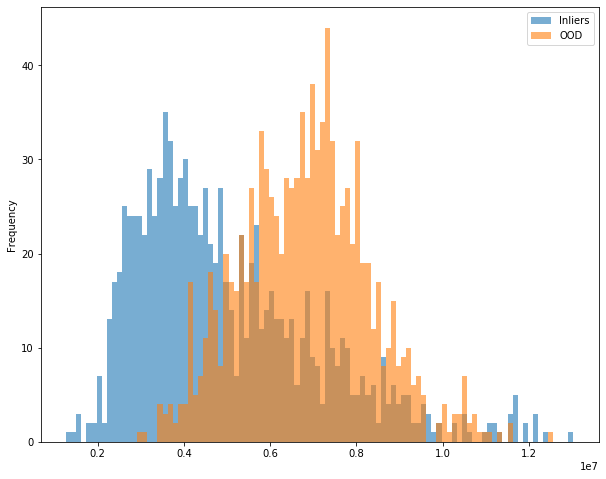

In [15]:
df.plot(kind="hist", bins=100, alpha=0.6, figsize=(10,8))

In [16]:
y_true = np.concatenate((np.zeros(x_batch.shape[0]),
                         np.ones(ood_batch.shape[0])))
y_scores = np.concatenate((inlier_ratio_score, ood_ratio_score))

prec,rec,thresh = precision_recall_curve(y_true, y_scores)

print("ROC-AUC: {:.4f}".format(roc_auc_score(y_true,y_scores)))
print("PR-AUC: {:.4f}".format(auc(rec,prec)))
print("Avg Prec: {:.4f}".format(average_precision_score(y_true,y_scores)))

ROC-AUC: 0.7749
PR-AUC: 0.6738
Avg Prec: 0.6748


## MNIST - 0 vs Rest

In [35]:
args = get_command_line_args(["--checkpoint_dir=longleaf_models/",
                              "--filters=64",
                              "--dataset=mnist_ood"])
configs.config_values = args

Parameters: 

experiment: train
dataset: mnist_ood
model: refinenet
filters: 64
num_L: 10
sigma_low: 0.01
sigma_high: 1.0
sigma_sequence: geometric
steps: 200000
learning_rate: 0.001
batch_size: 128
samples_dir: ./samples/
checkpoint_dir: longleaf_models/
checkpoint_freq: 5000
resume: True
resume_from: -1
init_samples: 
k: 10
eval_setting: sample



In [37]:
OOD_BATCH = 900
_,mnist_inliers, mnist_ood = get_ood_data("mnist_ood")

mnist_inliers = mnist_inliers.shuffle(10000).batch(OOD_BATCH)
mnist_inliers = mnist_inliers.cache().take(1)
mnist_ood = mnist_ood.batch(OOD_BATCH).cache().take(1)

Getting OOD Dataset...


In [38]:
save_dir, complete_model_name = utils.get_savemodel_dir()
model, optimizer, step = utils.try_load_model(save_dir,
                                              step_ckpt=configs.config_values.resume_from,
                                              verbose=True)

Trying to load latest model from longleaf_models/refinenet64_mnist_ood_L10/
Loaded model: longleaf_models/refinenet64_mnist_ood_L10/200410-192614_step_200000-1
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
images (InputLayer)             [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_142 (Conv2D)             (None, 28, 28, 64)   640         images[0][0]                     
__________________________________________________________________________________________________
idx_sigmas (InputLayer)         [(None,)]            0                                            
__________________________________________________________________________________________________
conditional_full_pre_activation

In [39]:
BEST_SIGMA_IDX = configs.config_values.num_L - 1
utils.get_sigma_levels()

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([1.        , 0.5994842 , 0.35938135, 0.21544345, 0.12915495,
       0.07742635, 0.04641588, 0.02782559, 0.016681  , 0.01      ],
      dtype=float32)>

### Getting Score Distributions w/ Lowest Sigma

In [40]:
%%time
for x_batch, ood_batch in zip(mnist_inliers, mnist_ood):
    idx_sigmas = tf.ones(x_batch.get_shape()[0],
                         dtype=tf.int32) * BEST_SIGMA_IDX
    
    logits = model([x_batch, idx_sigmas])
    
    ood_logits = model([ood_batch, idx_sigmas])

CPU times: user 8min 14s, sys: 7min 28s, total: 15min 42s
Wall time: 55.4 s


In [1]:
# score_norms = tf.norm(logits, axis=[1,2], ord="euclidean").numpy()
# ood_score_norms = tf.norm(ood_logits, axis=[1,2], ord="euclidean").numpy()

# df = pd.DataFrame(np.hstack((score_norms, ood_score_norms)),
#              columns=["Inliers", "OOD"])
# df.head()

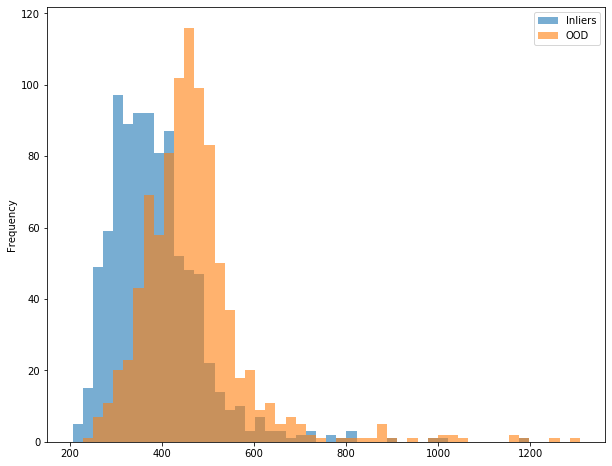

In [42]:
df.plot(kind="hist", bins=100, alpha=0.6, figsize=(10,8))

In [43]:
y_true = np.concatenate((np.zeros(x_batch.shape[0]),
                         np.ones(ood_batch.shape[0])))
y_scores = np.concatenate((score_norms, ood_score_norms))
prec,rec,thresh = precision_recall_curve(y_true, y_scores)

print("Lowest Sigma Scores")
print("-------------------")
print("ROC-AUC: {:.4f}".format(roc_auc_score(y_true,y_scores)))
print("PR-AUC: {:.4f}".format(auc(rec,prec)))
print("Avg Prec: {:.4f}".format(average_precision_score(y_true,y_scores)))

Lowest Sigma Scores
-------------------
ROC-AUC: 0.7475
PR-AUC: 0.6990
Avg Prec: 0.6996


> ## Multiple Sigma Scores

In [46]:
sigmas = utils.get_sigma_levels().numpy()
sigmas

array([1.        , 0.5994842 , 0.35938135, 0.21544345, 0.12915495,
       0.07742635, 0.04641588, 0.02782559, 0.016681  , 0.01      ],
      dtype=float32)

In [47]:
sigma_scores = {}

for x_batch, ood_batch in zip(mnist_inliers, mnist_ood):
    
    for i, sigma_i in enumerate(tqdm(sigmas, desc='Sampling for each sigma')):
    
        idx_sigmas = tf.ones(x_batch.get_shape()[0],
                             dtype=tf.int32) * i

        logits = model([x_batch, idx_sigmas])
        ood_logits = model([ood_batch, idx_sigmas])

        # L2-norm same as Frobenius
        score_norms = tf.norm(logits, axis=[1,2], ord="euclidean").numpy()
        ood_score_norms = tf.norm(ood_logits, axis=[1,2], ord="euclidean").numpy()
        
        sigma_scores[sigma_i] = (score_norms, ood_score_norms)

Sampling for each sigma: 100%|██████████| 10/10 [09:21<00:00, 56.11s/it]


### Distribution of Sigma Scores

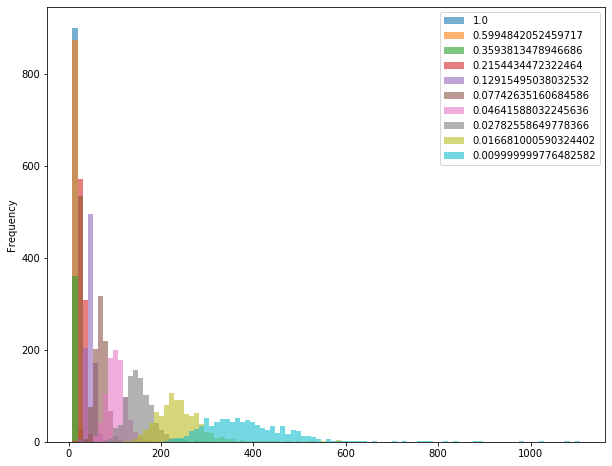

In [68]:
df = pd.DataFrame(np.hstack([x[0] for _,x in sigma_scores.items()]),
             columns=sigma_scores.keys())

df.plot(kind="hist", bins=100, alpha=0.6, figsize=(10,8))

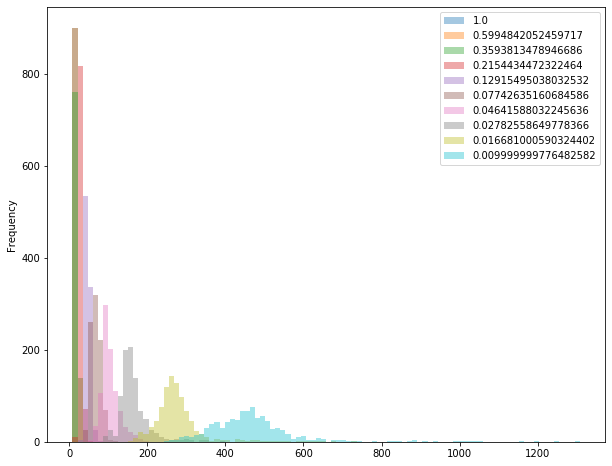

In [67]:
df = pd.DataFrame(np.hstack([x[1] for _,x in sigma_scores.items()]),
             columns=sigma_scores.keys())

df.plot(kind="hist", bins=100, alpha=0.4, figsize=(10,8))

In [49]:
inlier_w_avg = 0
ood_w_avg = 0

for sigma, (inlier_score, ood_score) in sigma_scores.items():
    inlier_w_avg += 1/sigma * inlier_score
    ood_w_avg += 1/sigma * ood_score

In [50]:
df = pd.DataFrame(np.hstack((inlier_w_avg, ood_w_avg)),
             columns=["Inliers", "OOD"])
df.head()

,Inliers,OOD
0,66127.687500,89718.703125
1,65414.558594,67593.078125
2,76602.281250,76747.273438
3,105570.750000,70833.007812
4,51449.976562,85211.953125


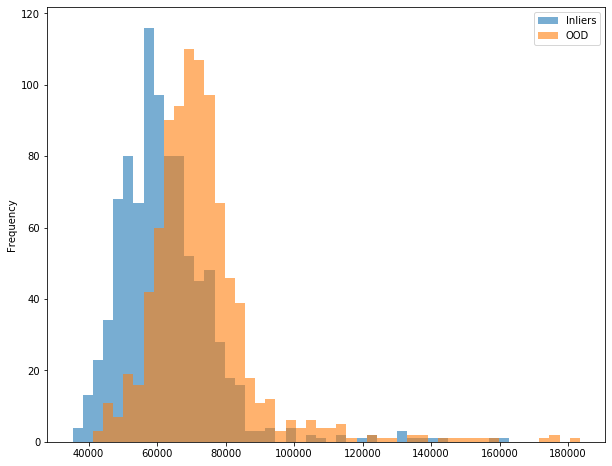

In [51]:
df.plot(kind="hist", bins=50, alpha=0.6, figsize=(10,8))

In [52]:
y_true = np.concatenate((np.zeros(x_batch.shape[0]),
                         np.ones(ood_batch.shape[0])))
y_scores = np.concatenate((inlier_w_avg, ood_w_avg))

prec,rec,thresh = precision_recall_curve(y_true, y_scores)

print("ROC-AUC: {:.4f}".format(roc_auc_score(y_true,y_scores)))
print("PR-AUC: {:.4f}".format(auc(rec,prec)))
print("Avg Prec: {:.4f}".format(average_precision_score(y_true,y_scores)))

ROC-AUC: 0.7380
PR-AUC: 0.6872
Avg Prec: 0.6878


### Removing "Background" Effect 

In [78]:
inlier_logits = []
ood_logits = []

for x_batch, ood_batch in zip(mnist_inliers, mnist_ood):
    
    for i, sigma_i in enumerate(tqdm(sigmas,desc='Sampling for each sigma')):
    
        idx_sigmas = tf.ones(x_batch.get_shape()[0],
                             dtype=tf.int32) * i

        inlier_logits.append(model([x_batch, idx_sigmas]))
        ood_logits.append(model([ood_batch, idx_sigmas]))

Sampling for each sigma: 100%|██████████| 10/10 [09:33<00:00, 57.35s/it]


In [116]:
inlier_ratio =  0
ood_ratio = 0

for sigma, inlier_, ood_ in zip(sigmas, inlier_logits, ood_logits):
    inlier_ratio += 1/sigma * inlier_
    ood_ratio += 1/sigma * ood_

In [117]:
inlier_ratio_score = tf.norm(inlier_ratio, axis=[1,2])
ood_ratio_score = tf.norm(ood_ratio, axis=[1,2])

df = pd.DataFrame(np.hstack((inlier_ratio_score, ood_ratio_score)),
             columns=["Inliers", "OOD"])
df.head()

,Inliers,OOD
0,55171.121094,86636.195312
1,46039.710938,64667.226562
2,55582.003906,73686.742188
3,53621.527344,67984.273438
4,90790.507812,78620.945312


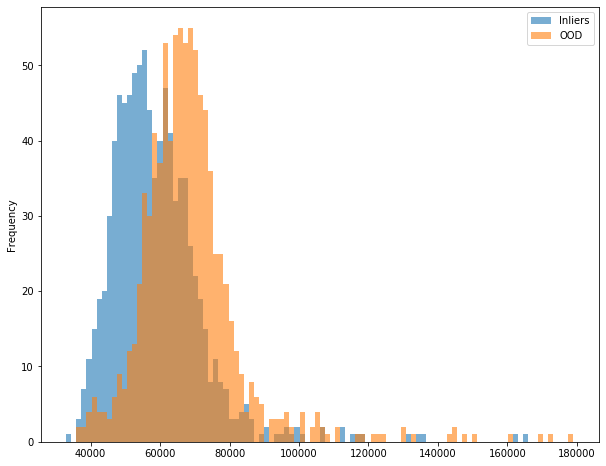

In [118]:
df.plot(kind="hist", bins=100, alpha=0.6, figsize=(10,8))

In [119]:
y_true = np.concatenate((np.zeros(x_batch.shape[0]),
                         np.ones(ood_batch.shape[0])))
y_scores = np.concatenate((inlier_ratio_score, ood_ratio_score))

prec,rec,thresh = precision_recall_curve(y_true, y_scores)

print("ROC-AUC: {:.4f}".format(roc_auc_score(y_true,y_scores)))
print("PR-AUC: {:.4f}".format(auc(rec,prec)))
print("Avg Prec: {:.4f}".format(average_precision_score(y_true,y_scores)))

ROC-AUC: 0.7321
PR-AUC: 0.6846
Avg Prec: 0.6852
